#  Time align shots

In this notebook I want to look at how Jason time aligned the data from different shots.
Two different time basis were used: 
1. the time elapsed since the start of the current ramp up.
2. the phase of the rotating kink mode
To determine the start of the current ramp up a current monitor measured the current flowing between the gun and the anode. This current was called bias current.

The phase of the rotating kink mode was determined with two fiducial magnetic probes. These probes were in the same position in every shot. The phase eas taken to be zero once the magntic signal in the fiducial probe a crossed zero. So all shots are in the same phase, however the amplitdues of oscillations varied during the rotating kink phase and from shot-to-shot.

# Import Libraries

In [2]:
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')
import MDSplus as mds

/Users/vonderlinden2/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Define data retrieval and plotting functions

Data is read from MDS+ into a dictionary.

In [3]:
def retrieve_fiduciary_signals(shot):
    rsx_tree = mds.Tree('rsx', shot)
    fiduciary_a_node = rsx_tree.getNode('\j_002_000')
    fiduciary_b_node = rsx_tree.getNode('\j_002_001')
    bias_current_node = rsx_tree.getNode('\j_002_004')
    fiduciary_a_data = fiduciary_a_node.getData() 
    fiduciary_b_data = fiduciary_b_node.getData()
    bias_current_data = bias_current_node.getData()
    fiduciary_a_raw = np.asarray(fiduciary_a_data.getValue())
    fiduciary_b_raw = np.asarray(fiduciary_b_data.getValue())
    bias_current_raw = np.asarray(bias_current_data.getValue())

    fiduciary_a_time = np.asarray(fiduciary_a_data.getDimensions()[0])*1e-3
    fiduciary_b_time = np.asarray(fiduciary_b_data.getDimensions()[0])*1e-3
    bias_current_time = np.asarray(bias_current_data.getDimensions()[0])*1e-3
    assert np.allclose(fiduciary_a_time, fiduciary_b_time) and np.allclose(fiduciary_a_time, bias_current_time)
    raw_signals = {'fid_a': fiduciary_a_raw,
                   'fid_b': fiduciary_b_raw,
                   'bias': bias_current_raw,
                   'time': fiduciary_a_time}
    return raw_signals

In [13]:
def plot_signals(raw_signals, log_scale=True, time_range=None, fid_b=False, zero_time=None, legend=False, show=True):
    plt.plot(raw_signals['time']*1e3, raw_signals['fid_a'], label='fiducial probe a')
    if fid_b:
        plt.plot(raw_signals['time']*1e3, raw_signals['fid_b'], label='fiducial probe b') 
    plt.plot(raw_signals['time']*1e3, raw_signals['bias'], label='bias current')
    plt.ylabel('raw Voltage [V]')
    plt.xlabel('time [ms]')
    if log_scale:
        plt.yscale('log')
    if time_range:
        plt.xlim(time_range)
    if legend:
        plt.legend()
    if zero_time:
        plt.axvline(zero_time)
    if show:
        plt.show()

# Look at one example shot

Here I only plot the raw voltages, the current should be multiplied by 2000 A/V.
The current start ramping up at about 1.7ms and the rotating kink phase starts at about 1.9ms.

In [10]:
raw_signals = retrieve_fiduciary_signals(16550)

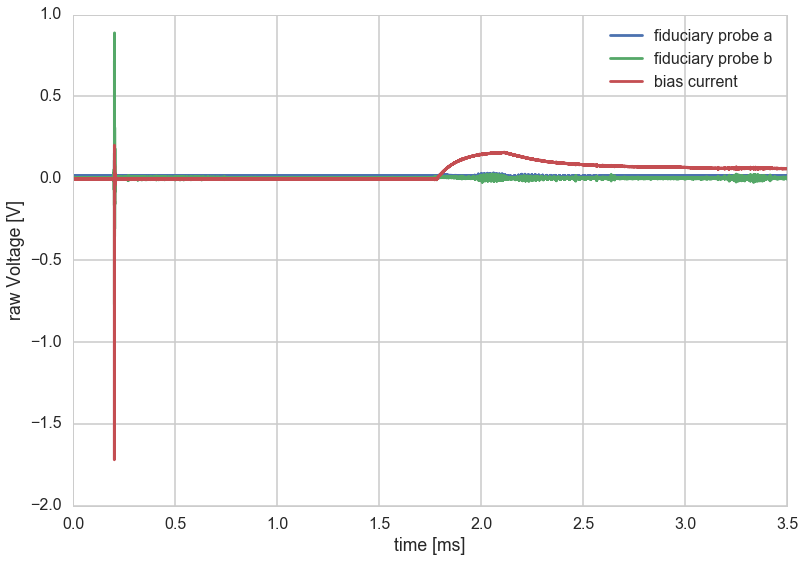

In [11]:
plot_signals(raw_signals, log_scale=False, fid_b=True, legend=True)

Zooming in on the intersting part. The discontinuity in slope of the bias current is due o crowbaring of the circuit.
The oscilations on the fiducial probes indicate the rotating kink phase. 
This hsot is interesting because the oscillation amplitude increases, decreases and the increases again. Usually only a single increase and decrease is observed.
The first decrease occurs at the same time as the crowbarring of the bias current circuit.

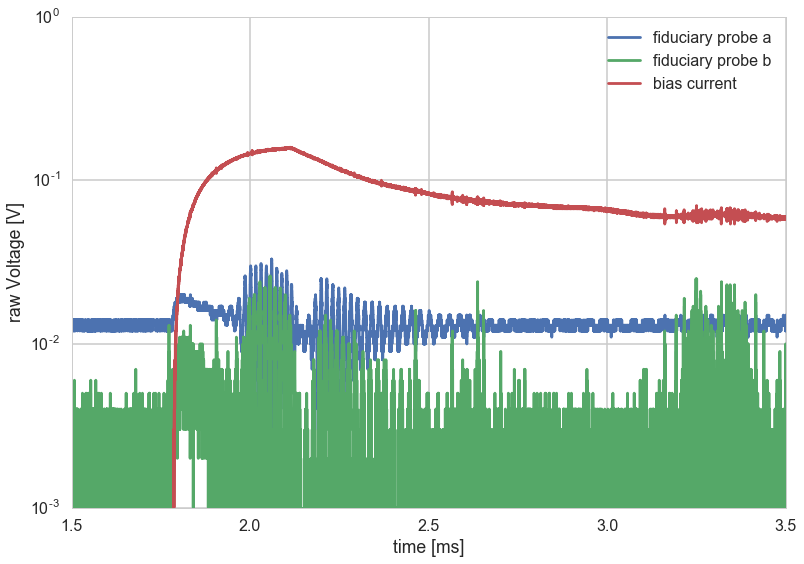

In [67]:
plot_signals(raw_signals, fid_b=True, legend=True, time_range=(1.5,3.5))

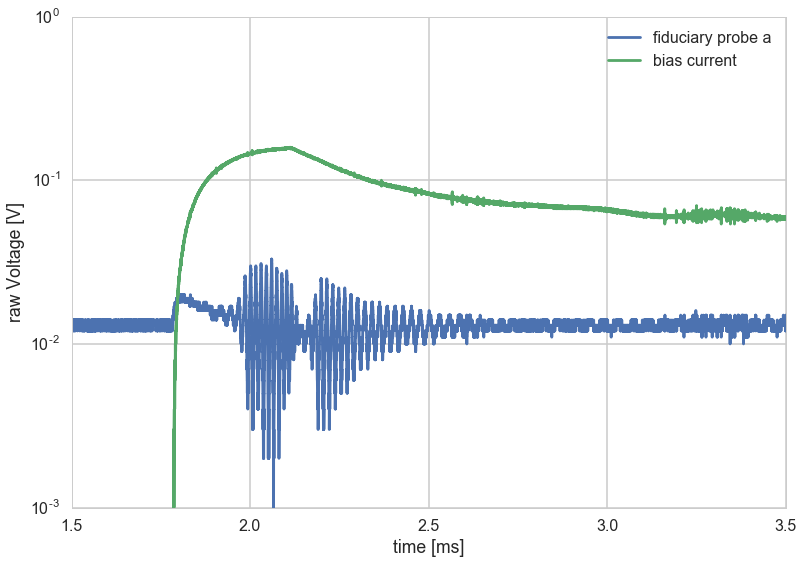

In [68]:
plot_signals(raw_signals, fid_b=False, legend=True, time_range=(1.5,3.5))

# A shot with more typical oscillation pattern

In [69]:
raw_signals = retrieve_fiduciary_signals(16670)

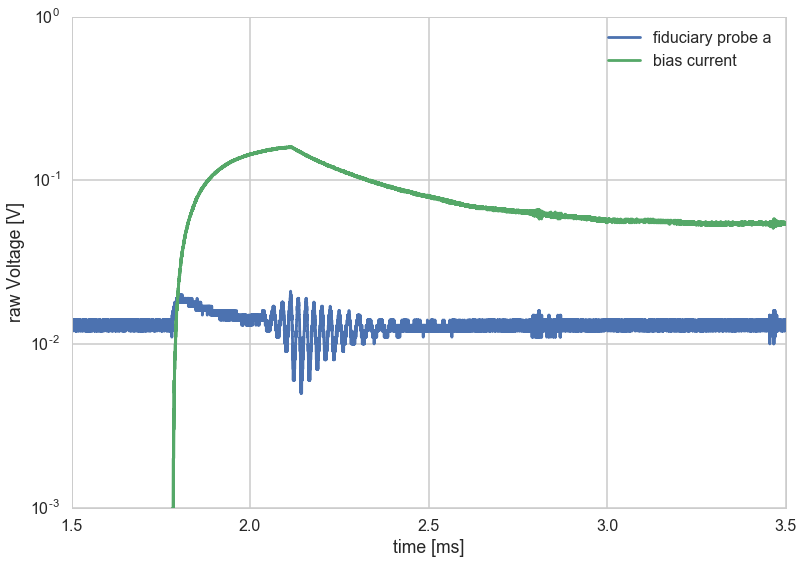

In [71]:
plot_signals(raw_signals, fid_b=False, legend=True, time_range=(1.5,3.5))

# Looking over several shots

The bias current trace is consistent especially before the rotating kink phase ends.
The oscillations in the fiducial probes start at different times, but look similar.

shot 16726 does not exist
shot 16727 does not exist
shot 16728 does not exist
shot 16729 does not exist


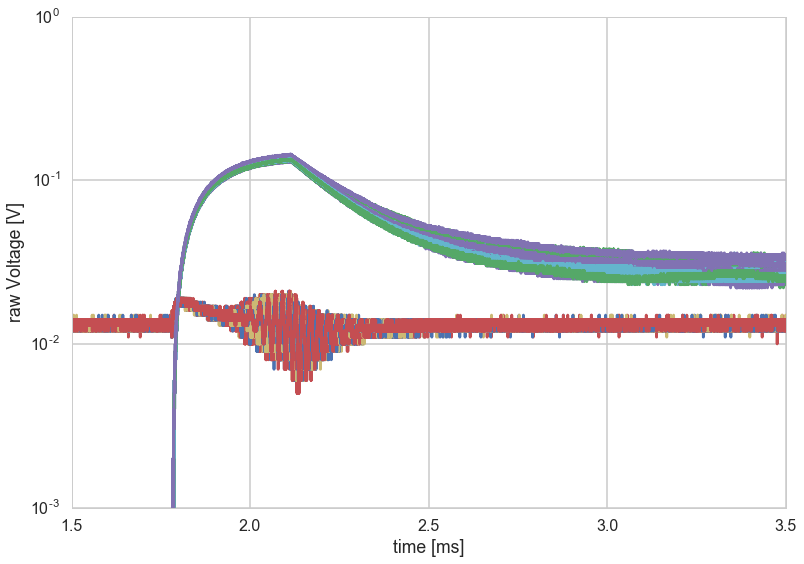

In [36]:
for shot in np.arange(16691, 16730):
    try:
        raw_signals = retrieve_fiduciary_signals(shot)
        plot_signals(raw_signals, time_range=(1.5,3.5), show=False)
    except:
        print 'shot %i does not exist' % shot
plt.show()

# Zomming in

shot 16726 does not exist
shot 16727 does not exist
shot 16728 does not exist
shot 16729 does not exist


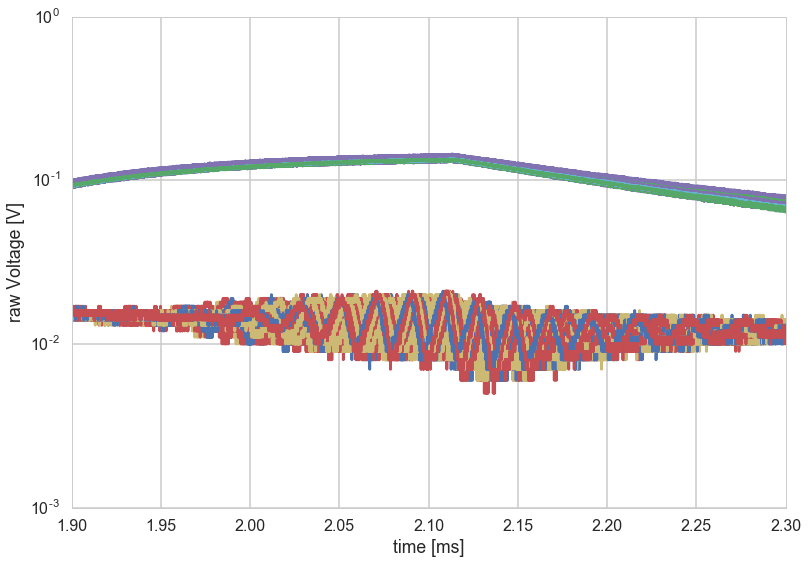

In [38]:
for shot in np.arange(16691, 16730):
    try:
        raw_signals = retrieve_fiduciary_signals(shot)
        plot_signals(raw_signals, time_range=(1.9,2.3), show=False)
    except:
        print 'shot %i does not exist' % shot
plt.show()

# Plotting over a range of shots from different days

Here I am including shots taken about a month apart.
We see some wider variance, and potentially some shots wer eno oscillations develop that need to be excluded from the analysis.

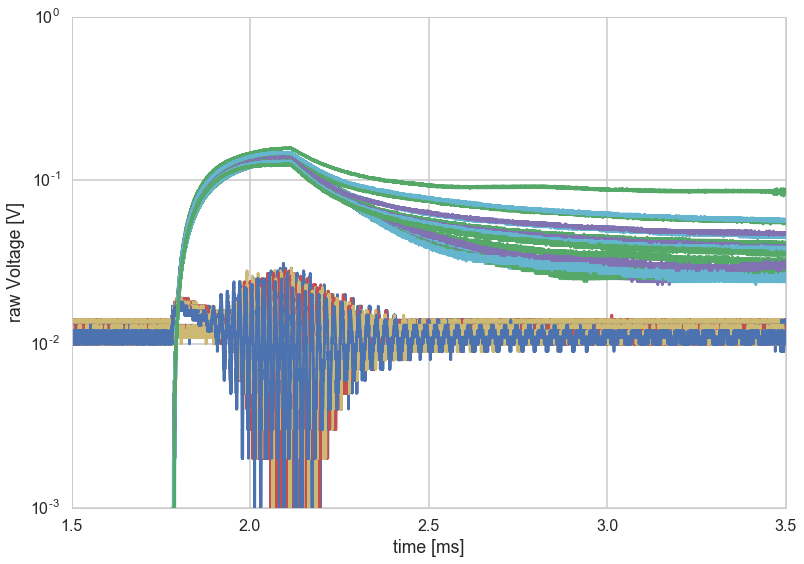

In [39]:
for shot in np.concatenate((np.arange(16691, 16700), np.arange(17344, 17360))):
    try:
        raw_signals = retrieve_fiduciary_signals(shot)
        plot_signals(raw_signals, time_range=(1.5,3.5), show=False)
    except:
        print 'shot %i does not exist' % shot
plt.show()

# Zooming in

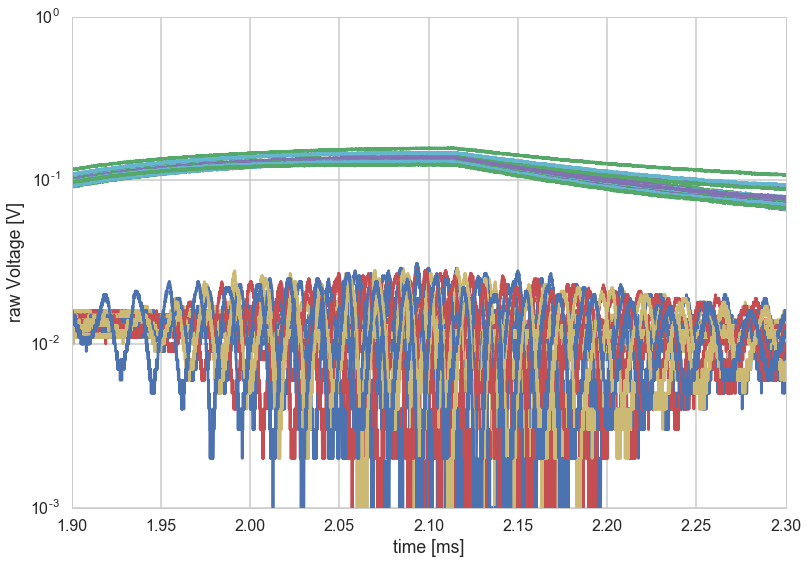

In [41]:
for shot in np.concatenate((np.arange(16691, 16700), np.arange(17344, 17360))):
    try:
        raw_signals = retrieve_fiduciary_signals(shot)
        plot_signals(raw_signals, time_range=(1.9,2.3), show=False)
    except:
        print 'shot %i does not exist' % shot
plt.show()

# Using the time align script

Jason wrote a script to determine the start of the current ramp up and the time at which the oscillation of the fiducial probe crosses zero.

### Determine start of current ramp up.

In [47]:
%%sh
source ~/.bashrc
idl -e "pro00100, 16670, trig_index, trig_time, period, current_rise=1 \
& print, 'trig index:', trig_index \
& print, 'trig_time:', trig_time \
& print, 'period:', period"

running ~/.bashrc...
modify IDL startup in /Users/vonderlinden2/rsx_drive/Applications/IDL/idl_startup.pro
executing that procedure now...
fundamental procedures are stored in /Users/vonderlinden2/rsx_drive/Applications/IDL/
use x11 xterm instead of terminal to maintain focus on the terminal
trig index:       35679
trig_time:      1.78395
period:       0


IDL Version 8.5, Mac OS X (darwin x86_64 m64).
(c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 5697-1.
Licensed for use by: ENERGY - LAWRENCE LIVERMORE NATIONAL LAB

% LOADCT: Loading table RED TEMPERATURE
% Compiled module: PRO00100.
% Compiled module: MDSOPEN.
% Compiled module: MDSVALUE.
% Compiled module: MDSCHECKARG.
% Compiled module: MDSISCLIENT.
% Compiled module: MDSIDLIMAGE.
% Compiled module: GET_SENSOR.
% Compiled module: PRO00160.
% Compiled module: MDSCLOSE.


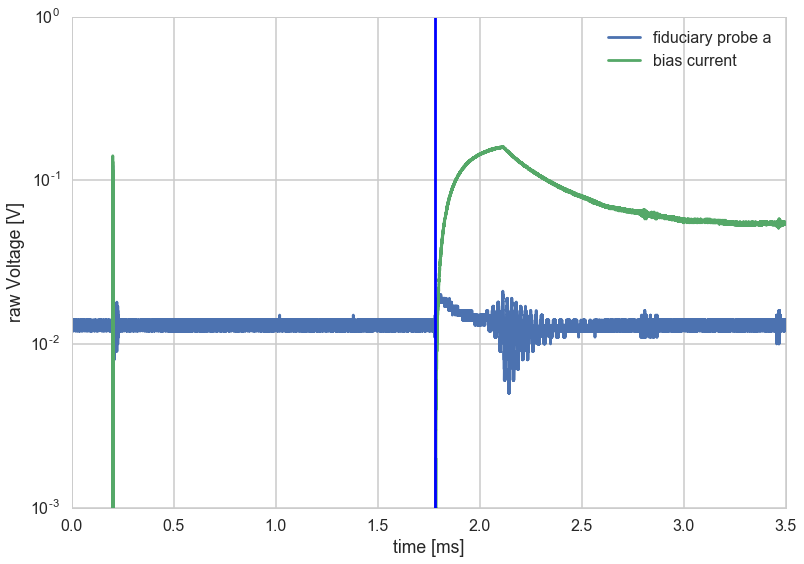

In [49]:
raw_signals = retrieve_fiduciary_signals(16670)
plot_signals(raw_signals, fid_b=False, legend=True, zero_time=1.78)

In [63]:
%%sh
source ~/.bashrc
idl -e "pro00100, 17300, trig_index, trig_time, period, current_rise=1 \
& print, 'trig index:', trig_index \
& print, 'trig_time:', trig_time \
& print, 'period:', period"

running ~/.bashrc...
modify IDL startup in /Users/vonderlinden2/rsx_drive/Applications/IDL/idl_startup.pro
executing that procedure now...
fundamental procedures are stored in /Users/vonderlinden2/rsx_drive/Applications/IDL/
use x11 xterm instead of terminal to maintain focus on the terminal
trig index:       35676
trig_time:      1.78380
period:       0


IDL Version 8.5, Mac OS X (darwin x86_64 m64).
(c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 5697-1.
Licensed for use by: ENERGY - LAWRENCE LIVERMORE NATIONAL LAB

% LOADCT: Loading table RED TEMPERATURE
% Compiled module: PRO00100.
% Compiled module: MDSOPEN.
% Compiled module: MDSVALUE.
% Compiled module: MDSCHECKARG.
% Compiled module: MDSISCLIENT.
% Compiled module: MDSIDLIMAGE.
% Compiled module: GET_SENSOR.
% Compiled module: PRO00160.
% Compiled module: MDSCLOSE.


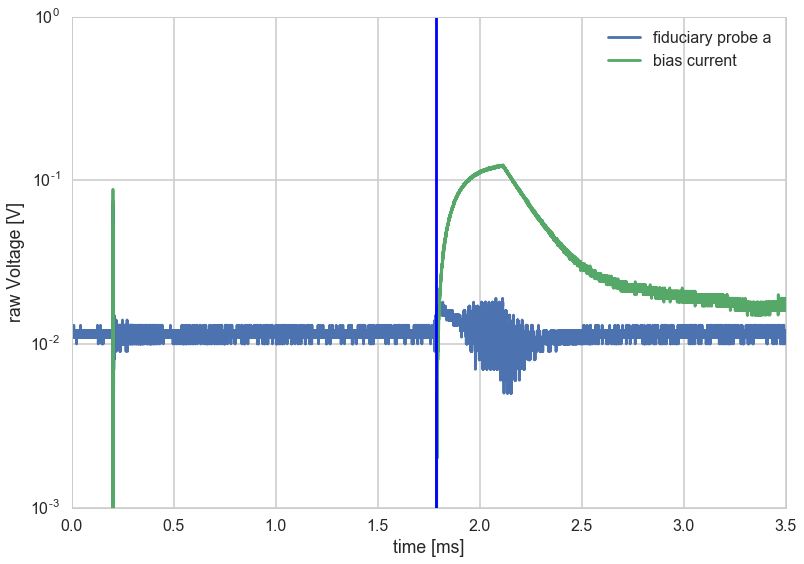

In [64]:
raw_signals = retrieve_fiduciary_signals(17300)
plot_signals(raw_signals, fid_b=False, legend=True, zero_time=1.78380)

# Phase identifciation in rotating kink oscillations

Looking at three shots we see that the script identifies a zero phase time point in the oscillations, however not a consitent section of the oscillation phase.
Sometimes the timepoint is the early grwoth phase of the oscillations soemtimes later.
Using these time points, the mach, triple and bdot measurements from different shots may have different amplitudes not just due to shot-to-shot variations but because sampling is due in different times of the life time of the rotating kink phase.

In [26]:
%%sh
source ~/.bashrc
idl -e "pro00100, 16670, trig_index, trig_time, period \
& print, 'trig index:', trig_index \
& print, 'trig_time:', trig_time \
& print, 'period:', period"

running ~/.bashrc...
modify IDL startup in /Users/vonderlinden2/rsx_drive/Applications/IDL/idl_startup.pro
executing that procedure now...
fundamental procedures are stored in /Users/vonderlinden2/rsx_drive/Applications/IDL/
use x11 xterm instead of terminal to maintain focus on the terminal
trig index:       41919
trig_time:      2.09595
period:    0.0219500


IDL Version 8.5, Mac OS X (darwin x86_64 m64).
(c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 5697-1.
Licensed for use by: ENERGY - LAWRENCE LIVERMORE NATIONAL LAB

% LOADCT: Loading table RED TEMPERATURE
% Compiled module: PRO00100.
% Compiled module: MDSOPEN.
% Compiled module: MDSVALUE.
% Compiled module: MDSCHECKARG.
% Compiled module: MDSISCLIENT.
% Compiled module: MDSIDLIMAGE.
% Compiled module: MDSCLOSE.


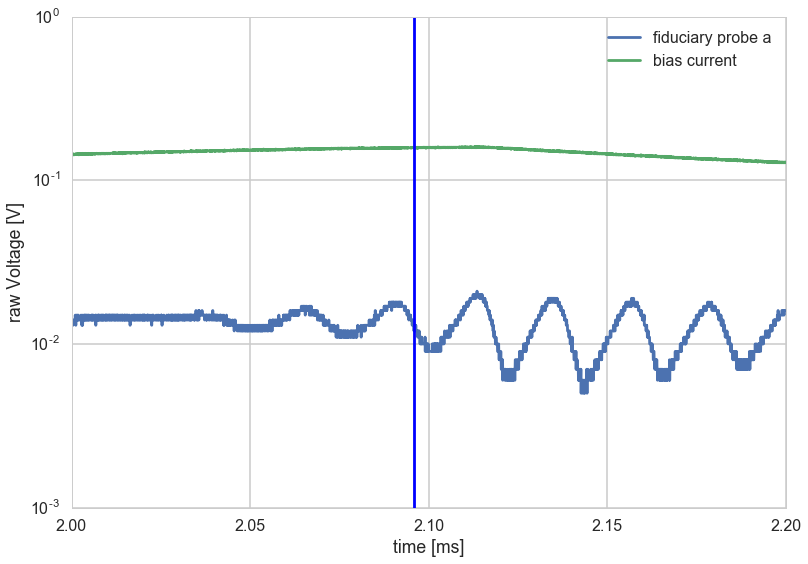

In [57]:
raw_signals = retrieve_fiduciary_signals(16670)
plot_signals(raw_signals, fid_b=False, legend=True, time_range=(2.0,2.2), zero_time=2.09595)

In [50]:
%%sh
source ~/.bashrc
idl -e "pro00100, 16680, trig_index, trig_time, period \
& print, 'trig index:', trig_index \
& print, 'trig_time:', trig_time \
& print, 'period:', period"

running ~/.bashrc...
modify IDL startup in /Users/vonderlinden2/rsx_drive/Applications/IDL/idl_startup.pro
executing that procedure now...
fundamental procedures are stored in /Users/vonderlinden2/rsx_drive/Applications/IDL/
use x11 xterm instead of terminal to maintain focus on the terminal
trig index:       41938
trig_time:      2.09690
period:    0.0188000


IDL Version 8.5, Mac OS X (darwin x86_64 m64).
(c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 5697-1.
Licensed for use by: ENERGY - LAWRENCE LIVERMORE NATIONAL LAB

% LOADCT: Loading table RED TEMPERATURE
% Compiled module: PRO00100.
% Compiled module: MDSOPEN.
% Compiled module: MDSVALUE.
% Compiled module: MDSCHECKARG.
% Compiled module: MDSISCLIENT.
% Compiled module: MDSIDLIMAGE.
% Compiled module: MDSCLOSE.


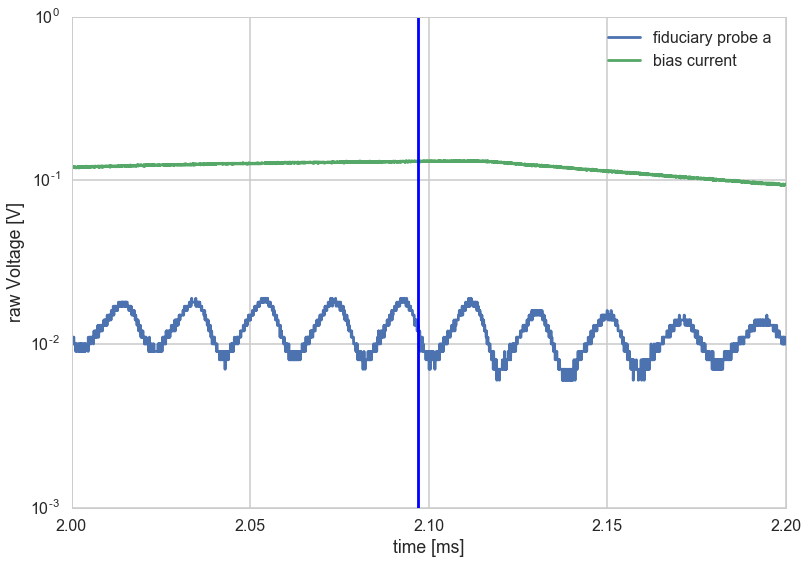

In [56]:
raw_signals = retrieve_fiduciary_signals(16680)
plot_signals(raw_signals, fid_b=False, legend=True, time_range=(2.0,2.2), zero_time=2.0969)

In [53]:
%%sh
source ~/.bashrc
idl -e "pro00100, 17300, trig_index, trig_time, period \
& print, 'trig index:', trig_index \
& print, 'trig_time:', trig_time \
& print, 'period:', period"

running ~/.bashrc...
modify IDL startup in /Users/vonderlinden2/rsx_drive/Applications/IDL/idl_startup.pro
executing that procedure now...
fundamental procedures are stored in /Users/vonderlinden2/rsx_drive/Applications/IDL/
use x11 xterm instead of terminal to maintain focus on the terminal
trig index:       41986
trig_time:      2.09930
period:    0.0159500


IDL Version 8.5, Mac OS X (darwin x86_64 m64).
(c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 5697-1.
Licensed for use by: ENERGY - LAWRENCE LIVERMORE NATIONAL LAB

% LOADCT: Loading table RED TEMPERATURE
% Compiled module: PRO00100.
% Compiled module: MDSOPEN.
% Compiled module: MDSVALUE.
% Compiled module: MDSCHECKARG.
% Compiled module: MDSISCLIENT.
% Compiled module: MDSIDLIMAGE.
% Compiled module: MDSCLOSE.


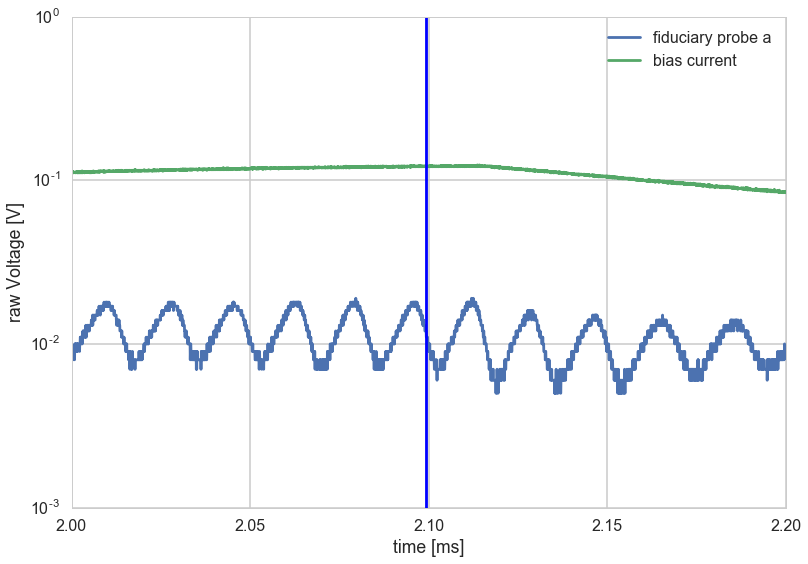

In [72]:
raw_signals = retrieve_fiduciary_signals(17300)
plot_signals(raw_signals, fid_b=False, legend=True, time_range=(2.0,2.2), zero_time=2.09930)

# Approaches going forward